## 目录

- **引言**
- **How to Fine-Tune BERT for Text Classification 论文**
  - 微调策略
  - ITPT：继续预训练
- **学术论文分类挑战赛微调**
  - huggingface工具介绍
  - bert模型介绍
  - 数据创建
  - 模型定义
  - 模型训练与评估
  - 模型改进


## 引言
- HuggingFace官网：https://github.com/huggingface/transformers
- HuggingFace模型地址：https://huggingface.co/
- 【论文解读】文本分类上分利器:Bert微调trick大全：https://zhuanlan.zhihu.com/p/386603816
- 论文链接：https://arxiv.org/pdf/1905.05583.pdf

## How to Fine-Tune BERT for Text Classification 论文
### 微调策略

1. 处理长文本 我们知道BERT 的最大序列长度为 512，BERT 应用于文本分类的第一个问题是如何处理长度大于 512 的文本。本文尝试了以下方式处理长文章。

**Truncation methods** 截断法 文章的关键信息位于开头和结尾。 我们可以使用三种不同的截断文本方法来执行 BERT 微调。

head-only: keep the first 510 tokens 头部510个字符，加上两个特殊字符刚好是512 ;
tail-only: keep the last 510 tokens;尾部510个字符，同理加上两个特殊字符刚好是512 ;
head+tail: empirically select the first 128and the last 382 tokens.：尾部结合

**Hierarchical methods** 层级法 输入的文本首先被分成k = L/510个片段，喂入 BERT 以获得 k 个文本片段的表示向量。 每个分数的表示是最后一层的 [CLS] 标记的隐藏状态，然后我们使用均值池化、最大池化和自注意力来组合所有分数的表示。


2. 不同层的特征 BERT 的每一层都捕获输入文本的不同特征。 文本研究了来自不同层的特征的有效性, 然后我们微调模型并记录测试错误率的性能。

![](https://pic4.zhimg.com/80/v2-ede05e688a667d62c822fe4a393b0b3f_720w.jpg)

我们可以看到：最后一层表征效果最好；最后4层进行max-pooling效果最好 


3. 灾难性遗忘 Catastrophic forgetting (灾难性遗忘)通常是迁移学习中的常见诟病，这意味着在学习新知识的过程中预先训练的知识会被遗忘。 因此，本文还研究了 BERT 是否存在灾难性遗忘问题。 我们用不同的学习率对 BERT 进行了微调，发现需要较低的学习率，例如 2e-5，才能使 BERT 克服灾难性遗忘问题。 在 4e-4 的较大学习率下，训练集无法收敛。

![](https://pic1.zhimg.com/80/v2-68a2635681f0161cc401aedf29195aa0_720w.jpg)

 这个也深有体会，当预训练模型失效不能够收敛的时候多检查下超参数是否设置有问题。 
 
 
 4. Layer-wise Decreasing Layer Rate 逐层降低学习率 下表 显示了不同基础学习率和衰减因子在 IMDb 数据集上的性能。 我们发现为下层分配较低的学习率对微调 BERT 是有效的，比较合适的设置是 ξ=0.95 和 lr=2.0e-5 

 为不同的BERT设置不同的学习率及衰减因子，BERT的表现如何？
 
 ![](https://pic4.zhimg.com/v2-2e131d76fe5ff19e152eb051e77ff673_b.png)
η^l代表第几层的学习率

### ITPT：继续预训练

ITPT：继续预训练
Bert是在通用的语料上进行预训练的，如果要在特定领域应用文本分类，数据分布一定是有一些差距的。这时候可以考虑进行深度预训练。
1. Within-task pre-training：Bert在训练语料上进行预训练 In-domain pre-training：在同一领域上的语料进行预训练 Cross-domain pre-training：在不同领域上的语料进行预训练
Within-task pretraining 
![](https://pic3.zhimg.com/v2-dcb4656c6fc49d2f7f3db2257f5e801a_b.png)
 BERT-ITPT-FiT 的意思是“BERT + with In-Task Pre-Training + Fine-Tuning”，上图表示IMDb 数据集上进行不同步数的继续预训练是有收益的。
 
 2. In-Domain 和 Cross-Domain Further Pre-Training 
![](https://pic4.zhimg.com/v2-d64ba326d0daed6c99b6dd8bd09a19bf_b.png)
 我们发现几乎所有进一步的预训练模型在所有七个数据集上的表现都比原始 BERT 基础模型。 一般来说，域内预训练可以带来比任务内预训练更好的性能。 在小句子级 TREC 数据集上，任务内预训练会损害性能，而在使用 Yah 的领域预训练中。Yah. A.语料库可以在TREC上取得更好的结果。
这篇论文与其他模型进行了比较，结果如下表所示： 
![](https://pic2.zhimg.com/v2-857a7f69695fe6f73d5eadfd14109c49_b.png)

## 学术论文分类挑战赛微调

### 1 导入包 

In [1]:
from transformers import AutoConfig,AutoModel,AutoTokenizer,AdamW,get_linear_schedule_with_warmup,logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,SequentialSampler,RandomSampler,DataLoader

import pandas as pd

# 导入transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup


# 导入torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# 常用包
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
torch.cuda.is_available()

True

### 2 加载数据

In [4]:
train = pd.read_csv('data/paper/train/train.csv', sep='\t')
test = pd.read_csv('data/paper/test/test.csv', sep='\t')
sub = pd.read_csv('data/paper/sample_submit.csv')



In [63]:
train.shape

(50000, 6)

### 3 数据预处理处理

### 3.1 文本拼接

In [5]:
# 拼接title与abstract
train['text'] = train['title'] + ' ' + train['abstract']
test['text'] = test['title'] + ' ' + test['abstract']

### 3.2  标签转换

In [6]:
label_id2cate = dict(enumerate(train.categories.unique()))
label_cate2id = {value: key for key, value in label_id2cate.items()}

train['label'] = train['categories'].map(label_cate2id)

In [62]:
# label_id2cate

In [7]:
train['categories'].value_counts()

cs.CV    11038
cs.CL     4260
cs.NI     3218
cs.CR     2798
cs.AI     2706
cs.DS     2509
cs.DC     1994
cs.SE     1940
cs.RO     1884
cs.LO     1741
cs.LG     1352
cs.SY     1292
cs.CY     1228
cs.DB      998
cs.GT      984
cs.HC      943
cs.PL      841
cs.IR      770
cs.CC      719
cs.NE      704
cs.CG      683
cs.OH      677
cs.SI      603
cs.DL      537
cs.DM      523
cs.FL      469
cs.AR      363
cs.CE      362
cs.GR      314
cs.MM      261
cs.ET      230
cs.MA      210
cs.NA      176
cs.SC      172
cs.SD      140
cs.PF      139
cs.MS      105
cs.OS       99
cs.GL       18
Name: categories, dtype: int64

In [8]:
train.head()

,paperid,title,abstract,categories,text,label
0,train_00000,"Hard but Robust, Easy but Sensitive: How Encod...",Neural machine translation (NMT) typically a...,cs.CL,"Hard but Robust, Easy but Sensitive: How Encod...",0
1,train_00001,An Easy-to-use Real-world Multi-objective Opti...,Although synthetic test problems are widely ...,cs.NE,An Easy-to-use Real-world Multi-objective Opti...,1
2,train_00002,Exploration of reproducibility issues in scien...,This is the first part of a small-scale expl...,cs.DL,Exploration of reproducibility issues in scien...,2
3,train_00003,Scheduled Sampling for Transformers,Scheduled sampling is a technique for avoidi...,cs.CL,Scheduled Sampling for Transformers Schedule...,0
4,train_00004,Hybrid Forests for Left Ventricle Segmentation...,Machine learning models produce state-of-the...,cs.CV,Hybrid Forests for Left Ventricle Segmentation...,3


###  4 认识Tokenizer
> Byte Pair Encoding（BPE）/WordPiece

### 4.1 将文本映射为id表示

In [64]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased' # 英文bert预训练模型
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [65]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

- 可以看到`BertTokenizer`的词表大小为30522
- 特殊符号为`special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}`

我们尝试使用`BertTokenizer`进行分词


In [66]:
train['title'][0]

'Hard but Robust, Easy but Sensitive: How Encoder and Decoder Perform in\n  Neural Machine Translation'

In [67]:
sample_txt = 'Hard but Robust, Easy but Sensitive: How Encoder and Decoder Perform in\n  Neural Machine Translation'

In [13]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'文本为: {sample_txt}')
print(f'分词的列表为: {tokens}')
print(f'词对应的唯一id: {token_ids}')

文本为: Hard but Robust, Easy but Sensitive: How Encoder and Decoder Perform in
  Neural Machine Translation
分词的列表为: ['hard', 'but', 'robust', ',', 'easy', 'but', 'sensitive', ':', 'how', 'en', '##code', '##r', 'and', 'deco', '##der', 'perform', 'in', 'neural', 'machine', 'translation']
词对应的唯一id: [2524, 2021, 15873, 1010, 3733, 2021, 7591, 1024, 2129, 4372, 16044, 2099, 1998, 21933, 4063, 4685, 1999, 15756, 3698, 5449]


### 4.2 特殊符号

In [14]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [15]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [16]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [17]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [18]:
tokenizer.mask_token, tokenizer.mask_token_id

('[MASK]', 103)

可以使用 encode_plus() 对句子进行分词，添加特殊符号

In [19]:
encoding=tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,# [CLS]和[SEP]
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',# Pytorch tensor张量

)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
E:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [20]:
encoding

{'input_ids': tensor([[  101,  2524,  2021, 15873,  1010,  3733,  2021,  7591,  1024,  2129,
          4372, 16044,  2099,  1998, 21933,  4063,  4685,  1999, 15756,  3698,
          5449,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

token ids的长度为32的张量

In [68]:
print(len(encoding['input_ids'][0]))

32


attention mask具有同样的长度

In [22]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

我们将ids反转为字，可以打印下每个字符是什么？

In [69]:
encoding['input_ids'][0]

tensor([  101,  2524,  2021, 15873,  1010,  3733,  2021,  7591,  1024,  2129,
         4372, 16044,  2099,  1998, 21933,  4063,  4685,  1999, 15756,  3698,
         5449,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [23]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'hard',
 'but',
 'robust',
 ',',
 'easy',
 'but',
 'sensitive',
 ':',
 'how',
 'en',
 '##code',
 '##r',
 'and',
 'deco',
 '##der',
 'perform',
 'in',
 'neural',
 'machine',
 'translation',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### 4.2 选取文本最大长度

In [24]:
token_lens = []

for txt in tqdm(train.text):
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:42<00:00, 308.46it/s]


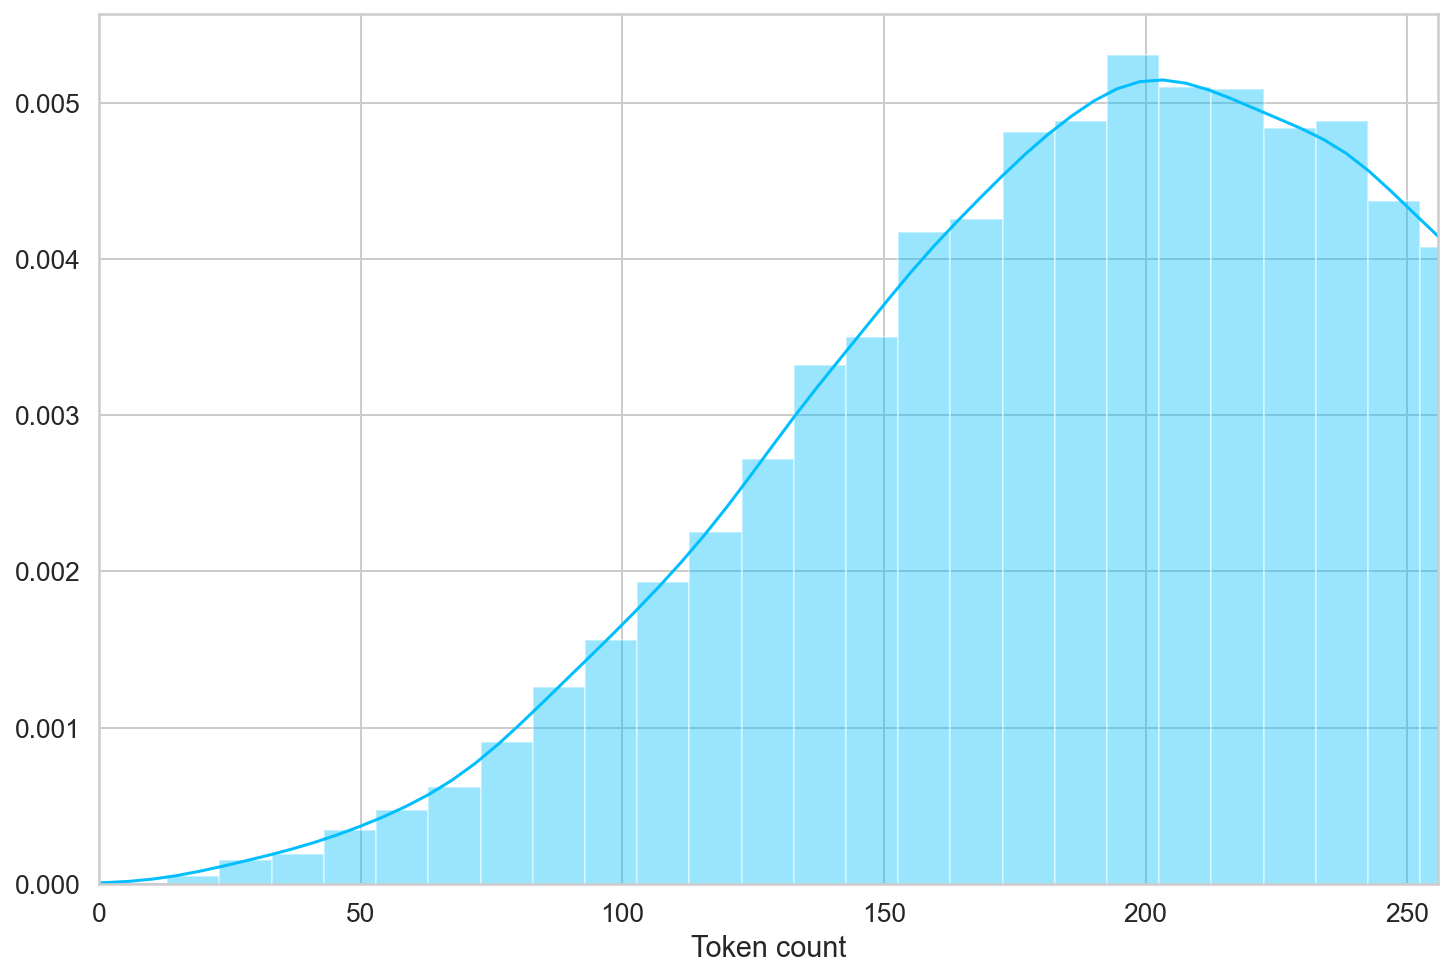

In [25]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

可以看到大多数文本的ids长度在300我们设置最大长度为300

In [70]:
pd.Series(token_lens).describe()

count    50000.000000
mean        14.866740
std          5.074499
min          3.000000
25%         11.000000
50%         14.000000
75%         18.000000
max         65.000000
dtype: float64

In [27]:
token_lens = []

for txt in tqdm(train.title):
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))
    
pd.Series(token_lens).describe()

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:15<00:00, 3202.46it/s]


count    50000.000000
mean        14.866740
std          5.074499
min          3.000000
25%         11.000000
50%         14.000000
75%         18.000000
max         65.000000
dtype: float64

In [28]:
# MAX_LEN=300
MAX_LEN=18 # 选取title

### 5 构建学术论文数据集

### 5.1 自定义数据集

In [29]:
class PaperDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,max_len):
        self.texts=texts
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,item):
        """
        item 为数据索引，迭代取第item条数据
        """
        text=str(self.texts[item])
        label=self.labels[item]
        
        encoding=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
#         print(encoding['input_ids'])
        return {
            'texts':text,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'labels':torch.tensor(label,dtype=torch.long)
        }
        

### 5.2 划分数据集并创建生成器

In [30]:
df_train, df_test = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((45000, 6), (2500, 6), (2500, 6))

In [31]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=PaperDataset(
        texts=df['text'].values,
        labels=df['label'].values,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
#         num_workers=4 # windows多线程
    )

In [32]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [33]:
next(iter(train_data_loader))

E:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'texts': ['A Mechanism for Fair Distribution of Resources without Payments   We design a mechanism for Fair and Efficient Distribution of Resources\n(FEDoR) in the presence of strategic agents. We consider a multiple-instances,\nBayesian setting, where in each round the preference of an agent over the set\nof resources is a private information. We assume that in each of r rounds n\nagents are competing for k non-identical indivisible goods, (n > k). In each\nround the strategic agents declare how much they value receiving any of the\ngoods in the specific round. The agent declaring the highest valuation receives\nthe good with the highest value, the agent with the second highest valuation\nreceives the second highest valued good, etc. Hence we assume a decision\nfunction that assigns goods to agents based on their valuations. The novelty of\nthe mechanism is that no payment scheme is required to achieve truthfulness in\na setting with rational/strategic agents. The FEDoR mechanism tak

In [34]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['texts', 'input_ids', 'attention_mask', 'labels'])

In [35]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([4, 18])
torch.Size([4, 18])
torch.Size([4])


## 6 基于Huggingface 的学术论文分类模型构建

![](https://pic1.zhimg.com/80/v2-edafe957e971fe53feeadd2477706cf4_720w.jpg)

In [71]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

![](https://jalammar.github.io/images/t/transformer_resideual_layer_norm_2.png)

In [38]:
encoding

{'input_ids': tensor([[  101,  2524,  2021, 15873,  1010,  3733,  2021,  7591,  1024,  2129,
          4372, 16044,  2099,  1998, 21933,  4063,  4685,  1999, 15756,  3698,
          5449,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [73]:
len(encoding['input_ids'][0])

32

In [39]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask'],
    return_dict = False
)

In [40]:
last_hidden_state

tensor([[[-0.5224, -0.3893,  0.0162,  ..., -0.2662, -0.4972,  0.7163],
         [-0.3814, -0.3655,  0.0178,  ..., -0.4456,  0.4600,  0.4876],
         [-0.2772, -0.0906,  0.7415,  ...,  0.3738, -0.7552,  1.3564],
         ...,
         [-0.1331, -0.2056,  0.1555,  ..., -0.4668, -0.5080,  0.2995],
         [-0.1369, -0.2696,  0.1501,  ..., -0.4964, -0.6130,  0.3469],
         [-0.1152, -0.2270,  0.1013,  ..., -0.5327, -0.5506,  0.4968]]],
       grad_fn=<NativeLayerNormBackward>)

In [41]:
last_hidden_state.shape # 

torch.Size([1, 32, 768])

1 条样本 32个token 768维向量

In [42]:
bert_model.config.hidden_size

768

In [43]:
pooled_output.shape
# 整体句子表示

torch.Size([1, 768])

### 定义分类模型

In [44]:
class PaperClassifier(nn.Module):
    def __init__(self, n_classes):
        super(PaperClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict = False
        )
        output = self.drop(pooled_output) # dropout
        return self.out(output)

In [45]:
class_names=train.categories.unique()
class_names

array(['cs.CL', 'cs.NE', 'cs.DL', 'cs.CV', 'cs.LG', 'cs.DS', 'cs.IR',
       'cs.RO', 'cs.DM', 'cs.CR', 'cs.AR', 'cs.NI', 'cs.AI', 'cs.SE',
       'cs.CG', 'cs.LO', 'cs.SY', 'cs.GR', 'cs.PL', 'cs.SI', 'cs.OH',
       'cs.HC', 'cs.MA', 'cs.GT', 'cs.ET', 'cs.FL', 'cs.CC', 'cs.DB',
       'cs.DC', 'cs.CY', 'cs.CE', 'cs.MM', 'cs.NA', 'cs.PF', 'cs.OS',
       'cs.SD', 'cs.SC', 'cs.MS', 'cs.GL'], dtype=object)

In [46]:
model = PaperClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
data

{'texts': ['A Mechanism for Fair Distribution of Resources without Payments   We design a mechanism for Fair and Efficient Distribution of Resources\n(FEDoR) in the presence of strategic agents. We consider a multiple-instances,\nBayesian setting, where in each round the preference of an agent over the set\nof resources is a private information. We assume that in each of r rounds n\nagents are competing for k non-identical indivisible goods, (n > k). In each\nround the strategic agents declare how much they value receiving any of the\ngoods in the specific round. The agent declaring the highest valuation receives\nthe good with the highest value, the agent with the second highest valuation\nreceives the second highest valued good, etc. Hence we assume a decision\nfunction that assigns goods to agents based on their valuations. The novelty of\nthe mechanism is that no payment scheme is required to achieve truthfulness in\na setting with rational/strategic agents. The FEDoR mechanism tak

In [48]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 18])
torch.Size([4, 18])


In [49]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0185, 0.0210, 0.0460, 0.0769, 0.0320, 0.0516, 0.0436, 0.0140, 0.0228,
         0.0179, 0.0208, 0.0173, 0.0374, 0.0402, 0.0048, 0.0138, 0.0169, 0.0125,
         0.0239, 0.0135, 0.0168, 0.0225, 0.0180, 0.0455, 0.0179, 0.0347, 0.0147,
         0.0086, 0.0290, 0.0186, 0.0382, 0.0260, 0.0135, 0.0292, 0.0184, 0.0286,
         0.0153, 0.0420, 0.0174],
        [0.0227, 0.0282, 0.0549, 0.0286, 0.0408, 0.0379, 0.0335, 0.0216, 0.0237,
         0.0148, 0.0204, 0.0228, 0.0167, 0.0691, 0.0070, 0.0164, 0.0165, 0.0121,
         0.0201, 0.0233, 0.0230, 0.0157, 0.0314, 0.0478, 0.0235, 0.0302, 0.0165,
         0.0201, 0.0380, 0.0202, 0.0330, 0.0235, 0.0285, 0.0302, 0.0246, 0.0148,
         0.0145, 0.0155, 0.0178],
        [0.0377, 0.0221, 0.0599, 0.0283, 0.0305, 0.0177, 0.0295, 0.0164, 0.0299,
         0.0203, 0.0209, 0.0229, 0.0326, 0.0548, 0.0091, 0.0135, 0.0216, 0.0137,
         0.0275, 0.0151, 0.0159, 0.0180, 0.0176, 0.0327, 0.0189, 0.0179, 0.0176,
         0.0262, 0.0277, 0.0192, 0.0581, 

## 7 模型训练

In [50]:
EPOCHS = 2 # 训练轮数

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [51]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() # 验证预测模式

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [53]:

history = defaultdict(list) # 记录10轮loss和acc
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


  0%|                                                                                | 1/11250 [00:00<31:47,  5.90it/s]

Epoch 1/2
----------


100%|████████████████████████████████████████████████████████████████████████████| 11250/11250 [15:57<00:00, 11.75it/s]


Train loss 1.5526684251332448 accuracy 0.5925777777777778
Val   loss 1.246055817374587 accuracy 0.6752



  0%|                                                                                | 2/11250 [00:00<16:04, 11.66it/s]

Epoch 2/2
----------


100%|████████████████████████████████████████████████████████████████████████████| 11250/11250 [16:20<00:00, 11.48it/s]


Train loss 0.9735033280969287 accuracy 0.7378222222222223
Val   loss 1.2093796543505042 accuracy 0.6992



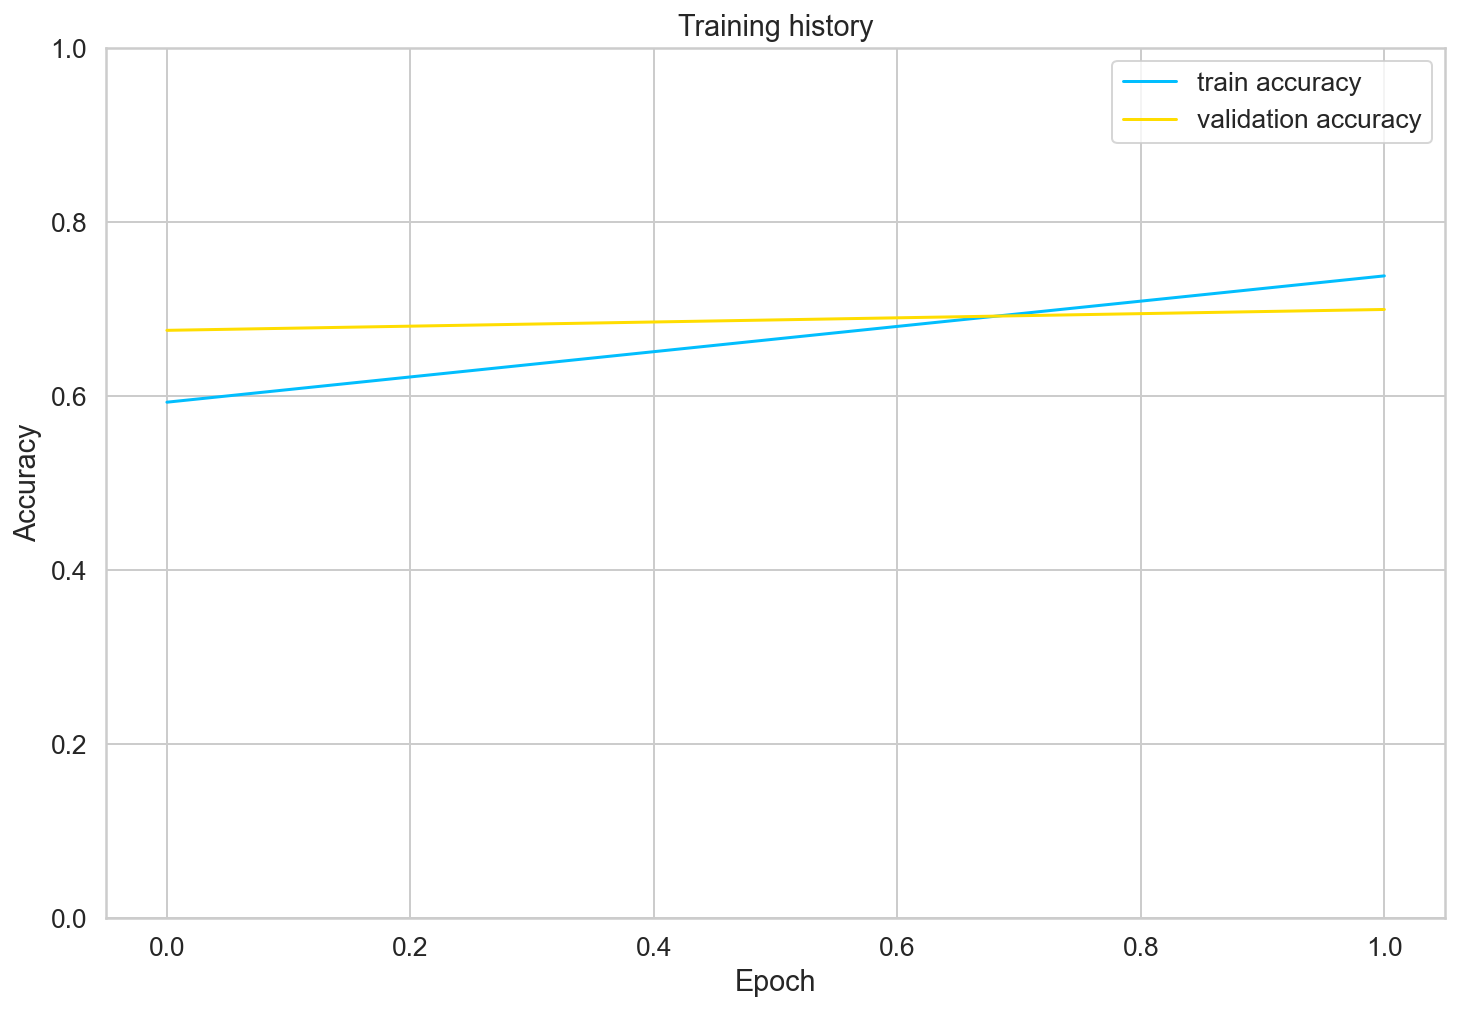

In [54]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### 8 模型评估

In [55]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6728000000000001

In [56]:
def get_predictions(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["texts"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values


In [57]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [58]:
print(classification_report(y_test, y_pred, target_names=[str(label) for label in class_names]))

              precision    recall  f1-score   support

       cs.CL       0.82      0.82      0.82       206
       cs.NE       0.48      0.48      0.48        33
       cs.DL       0.65      0.71      0.68        24
       cs.CV       0.84      0.90      0.87       534
       cs.LG       0.41      0.45      0.43        65
       cs.DS       0.63      0.72      0.67       130
       cs.IR       0.59      0.59      0.59        29
       cs.RO       0.74      0.75      0.74        95
       cs.DM       0.47      0.22      0.30        36
       cs.CR       0.74      0.82      0.77       136
       cs.AR       0.48      0.43      0.45        23
       cs.NI       0.72      0.76      0.74       166
       cs.AI       0.58      0.53      0.55       134
       cs.SE       0.69      0.76      0.72        93
       cs.CG       0.49      0.74      0.59        31
       cs.LO       0.52      0.57      0.54        86
       cs.SY       0.61      0.61      0.61        71
       cs.GR       1.00    

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


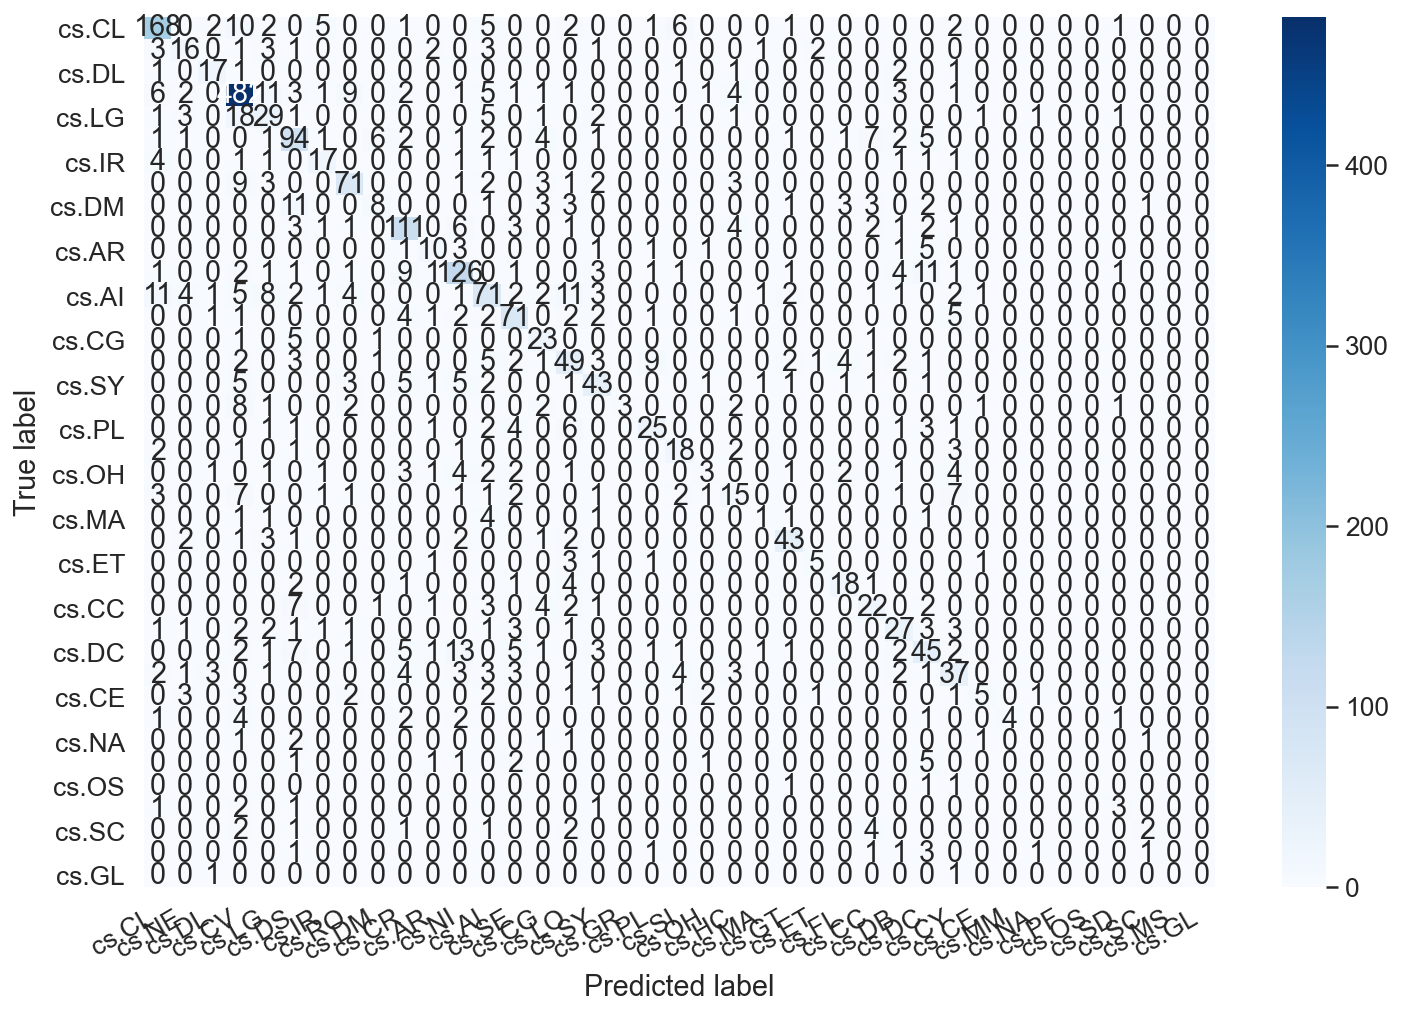

In [59]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


## 9 模型预测

In [74]:
sample_text='Hard but Robust, Easy but Sensitive: How Encod.'
encoded_text = tokenizer.encode_plus(
  sample_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [77]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sample text: {sample_text}')
print(f'Danger label  : {label_id2cate[prediction.cpu().numpy()[0]]}')

Sample text: Hard but Robust, Easy but Sensitive: How Encod.
Danger label  : cs.CR


### 改进1 Last 4 Layers Concatenating

In [ ]:
class LastFourModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        config = AutoConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
        config.update({'output_hidden_states':True})
        self.model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)
        self.linear = nn.Linear(4*HIDDEN_SIZE, n_classes)
        
    def forward(self, input_ids, attention_mask):
        
        outputs = self.model(input_ids, attention_mask)
        all_hidden_states = torch.stack(outputs[2])
        concatenate_pooling = torch.cat(
            (all_hidden_states[-1], all_hidden_states[-2], all_hidden_states[-3], all_hidden_states[-4]), -1
        )
        concatenate_pooling = concatenate_pooling[:,0]
        output = self.linear(concatenate_pooling)
        
        return soutput

## 改进2 模型层间差分学习率

In [ ]:
def get_parameters(model, model_init_lr, multiplier, classifier_lr):
    parameters = []
    lr = model_init_lr
    for layer in range(12,-1,-1):
        layer_params = {
            'params': [p for n,p in model.named_parameters() if f'encoder.layer.{layer}.' in n],
            'lr': lr
        }
        parameters.append(layer_params)
        lr *= multiplier
    classifier_params = {
        'params': [p for n,p in model.named_parameters() if 'layer_norm' in n or 'linear' in n 
                   or 'pooling' in n],
        'lr': classifier_lr
    }
    parameters.append(classifier_params)
    return parameters
parameters=get_parameters(model,2e-5,0.95, 1e-4)
optimizer=AdamW(parameters)

In [80]:
[name[0] for name in model.named_parameters()]

['bert.embeddings.word_embeddings.weight',
 'bert.embeddings.position_embeddings.weight',
 'bert.embeddings.token_type_embeddings.weight',
 'bert.embeddings.LayerNorm.weight',
 'bert.embeddings.LayerNorm.bias',
 'bert.encoder.layer.0.attention.self.query.weight',
 'bert.encoder.layer.0.attention.self.query.bias',
 'bert.encoder.layer.0.attention.self.key.weight',
 'bert.encoder.layer.0.attention.self.key.bias',
 'bert.encoder.layer.0.attention.self.value.weight',
 'bert.encoder.layer.0.attention.self.value.bias',
 'bert.encoder.layer.0.attention.output.dense.weight',
 'bert.encoder.layer.0.attention.output.dense.bias',
 'bert.encoder.layer.0.attention.output.LayerNorm.weight',
 'bert.encoder.layer.0.attention.output.LayerNorm.bias',
 'bert.encoder.layer.0.intermediate.dense.weight',
 'bert.encoder.layer.0.intermediate.dense.bias',
 'bert.encoder.layer.0.output.dense.weight',
 'bert.encoder.layer.0.output.dense.bias',
 'bert.encoder.layer.0.output.LayerNorm.weight',
 'bert.encoder.layer

## 改进3 ITPT

In [ ]:
import warnings
import pandas as pd
from transformers import (AutoModelForMaskedLM,
                          AutoTokenizer, LineByLineTextDataset,
                          DataCollatorForLanguageModeling,
                          Trainer, TrainingArguments)

warnings.filterwarnings('ignore')

train_data = pd.read_csv('data/train/train.csv', sep='\t')
test_data = pd.read_csv('data/test/test.csv', sep='\t')
train_data['text'] = train_data['title'] + '.' + train_data['abstract']
test_data['text'] = test_data['title'] + '.' + test_data['abstract']
data = pd.concat([train_data, test_data])
data['text'] = data['text'].apply(lambda x: x.replace('\n', ''))

text = '\n'.join(data.text.tolist())

with open('text.txt', 'w') as f:
    f.write(text)

model_name = 'roberta-base'
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained('./paper_roberta_base')

train_dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="text.txt",  # mention train text file here
    block_size=256)

valid_dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="text.txt",  # mention valid text file here
    block_size=256)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

training_args = TrainingArguments(
    output_dir="./paper_roberta_base_chk",  # select model path for checkpoint
    overwrite_output_dir=True,
    num_train_epochs=5,# 轮数不要设置的太大
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    evaluation_strategy='steps',
    save_total_limit=2,
    eval_steps=200,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    prediction_loss_only=True,
    report_to="none")

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset)

trainer.train()
trainer.save_model(f'./paper_roberta_base')


## ChallengeHub

分享人：致Great ChallengeHub成员 中国人民大学硕士

![](https://img-blog.csdnimg.cn/fcef57e247724f02bf84533e13cfa523.jpg)

关注回复**“学术论文”** 获取本notebook和此前**simpletransformers** baseline